In [233]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict
import requests
import PIL


import sklearn
import sklearn.svm
import sklearn.model_selection
from sklearn.model_selection import train_test_split



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Different Models and Layers

In [234]:
batch_size = 8
num_epochs = 5
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes=1000, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [235]:
densenet, input_size = initialize_model("densenet")
densenet.eval()

densenet_bottom = copy.deepcopy(densenet)
densenet_top = densenet.classifier

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
    
densenet_bottom.classifier = Identity()

In [236]:
squeezenet, input_size = initialize_model("squeezenet")
squeezenet.eval()

squeezenet_bottom_ = copy.deepcopy(squeezenet)
squeezenet_top = squeezenet.classifier

squeezenet_bottom_.classifier = Identity()
    
def squeezenet_bottom(t):
    return squeezenet_bottom_(t).view((-1, 512, 13, 13))

In [221]:
resnet, input_size = initialize_model("resnet")
resnet.eval()

resnet_bottom = copy.deepcopy(resnet)
resnet_top = resnet.fc

resnet_bottom.fc = Identity()

In [225]:
vggnet, input_size = initialize_model("vgg")
vggnet.eval()

vggnet_bottom = copy.deepcopy(vggnet)
vggnet_top = vggnet.classifier

vggnet_bottom.classifier = Identity()

In [153]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [154]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\lion.jpg").convert("RGB")
tensor = data_transforms["val"](img).unsqueeze(0)

In [161]:
squeezenet_bottom(tensor).shape

torch.Size([1, 86528])

In [267]:
print(np.allclose(densenet(tensor), densenet_top(densenet_bottom(tensor))))
print(np.allclose(resnet(tensor), resnet_top(resnet_bottom(tensor))))
print(np.allclose(vggnet(tensor), vggnet_top(vggnet_bottom(tensor))))
print(np.allclose(squeezenet(tensor).squeeze(), squeezenet_top(squeezenet_bottom(tensor)).squeeze()))

True
True
True
True


In [300]:
models = [densenet, resnet, vggnet, squeezenet]
tops = [densenet_top, resnet_top, vggnet_top, squeezenet_top]
bottoms = [densenet_bottom, resnet_bottom, vggnet_bottom, squeezenet_bottom]
names = ['densenet', 'resnet', 'vgg', 'squeezenet']

for model, top, bottom, name in zip(models, tops, bottoms, names):
    print(name)
    concept_dict = {}
    concept_dir = "concept_data/"
    transform = data_transforms['val']

    # iterate through each folder
    for concept in tqdm.tqdm(os.listdir(concept_dir)):
        if concept in concept_dict:
            continue

        all_embeddings = []
        all_labels = []

        image_dataset = datasets.ImageFolder(os.path.join(concept_dir,concept), transform)
        dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

        # load all of the images, get the embeddings
        for inputs, labels in dataloaders:
            embeddings = bottom(inputs)
            all_embeddings.extend(embeddings.detach().numpy())
            all_labels.extend(labels.detach().numpy())

        # train an svm on the pos, neg
        X_train, X_test, y_train, y_test = train_test_split(all_embeddings, all_labels)
        svm = sklearn.svm.SVC(kernel="linear", C=0.001, probability=True)
        svm.fit(X_train, y_train)
        train_acc = svm.score(X_train, y_train)
        test_acc = svm.score(X_test, y_test)

        # print test accuaracy
        print(train_acc, test_acc)
        # store svm coefs in dictionary
        concept_dict[concept] = (svm.coef_, train_acc, test_acc)      
    
    pickle.dump(concept_dict, open('{}_concepts_170.pkl'.format(name), 'wb'))    

  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

densenet


  1%|▍                                                                               | 1/170 [00:33<1:35:22, 33.86s/it]

0.9795918367346939 0.94


  1%|▉                                                                               | 2/170 [00:55<1:24:46, 30.28s/it]

0.87 0.8235294117647058


  2%|█▍                                                                              | 3/170 [01:16<1:16:01, 27.31s/it]

0.851063829787234 0.8125


  2%|█▉                                                                              | 4/170 [01:48<1:19:20, 28.68s/it]

0.9060402684563759 0.9


  3%|██▎                                                                             | 5/170 [02:19<1:21:12, 29.53s/it]

0.8851351351351351 0.86


  4%|██▊                                                                             | 6/170 [02:53<1:24:28, 30.90s/it]

0.9054054054054054 0.7


  4%|███▎                                                                            | 7/170 [03:25<1:24:39, 31.16s/it]

0.8851351351351351 0.76


  5%|███▊                                                                            | 8/170 [03:56<1:23:56, 31.09s/it]

0.9054054054054054 0.84


  5%|████▏                                                                           | 9/170 [04:25<1:22:12, 30.63s/it]

0.9621212121212122 0.8181818181818182


  6%|████▋                                                                          | 10/170 [05:08<1:31:18, 34.24s/it]

0.912751677852349 0.8


  6%|█████                                                                          | 11/170 [05:45<1:32:52, 35.05s/it]

0.9662162162162162 0.9


  7%|█████▌                                                                         | 12/170 [06:23<1:34:49, 36.01s/it]

0.9328859060402684 0.78


  8%|██████                                                                         | 13/170 [06:59<1:34:01, 35.93s/it]

0.768 0.7857142857142857


  8%|██████▌                                                                        | 14/170 [07:46<1:41:46, 39.14s/it]

0.9060402684563759 0.84


  9%|██████▉                                                                        | 15/170 [08:16<1:34:08, 36.44s/it]

0.9824561403508771 0.7894736842105263


  9%|███████▍                                                                       | 16/170 [08:53<1:34:26, 36.80s/it]

0.972972972972973 0.98


 10%|███████▉                                                                       | 17/170 [09:30<1:33:21, 36.61s/it]

0.9145299145299145 0.825


 11%|████████▎                                                                      | 18/170 [11:02<2:14:52, 53.24s/it]

0.8927444794952681 0.7547169811320755


 11%|████████▊                                                                      | 19/170 [11:46<2:07:17, 50.58s/it]

0.9060402684563759 0.84


 12%|█████████▎                                                                     | 20/170 [12:17<1:51:48, 44.72s/it]

0.9357798165137615 0.918918918918919


 12%|█████████▊                                                                     | 21/170 [12:52<1:43:28, 41.67s/it]

0.8926174496644296 0.72


 13%|██████████▏                                                                    | 22/170 [13:37<1:45:48, 42.90s/it]

0.9662162162162162 0.96


 14%|██████████▋                                                                    | 23/170 [14:18<1:43:44, 42.34s/it]

0.972972972972973 0.96


 14%|███████████▏                                                                   | 24/170 [14:52<1:36:42, 39.75s/it]

0.9856115107913669 0.8723404255319149


 15%|███████████▌                                                                   | 25/170 [15:31<1:35:11, 39.39s/it]

0.8918918918918919 0.92


 15%|████████████                                                                   | 26/170 [15:57<1:25:20, 35.56s/it]

1.0 1.0


 16%|████████████▌                                                                  | 27/170 [16:33<1:24:32, 35.47s/it]

0.9659863945578231 0.94


 16%|█████████████                                                                  | 28/170 [17:13<1:27:18, 36.89s/it]

0.8795180722891566 0.6964285714285714


 17%|█████████████▍                                                                 | 29/170 [17:48<1:25:35, 36.42s/it]

0.8581081081081081 0.68


 18%|█████████████▉                                                                 | 30/170 [18:24<1:24:36, 36.26s/it]

0.972972972972973 0.88


 18%|██████████████▍                                                                | 31/170 [18:58<1:22:09, 35.46s/it]

0.9391891891891891 0.82


 19%|██████████████▊                                                                | 32/170 [19:30<1:19:15, 34.46s/it]

0.9527027027027027 0.98


 19%|███████████████▎                                                               | 33/170 [20:01<1:16:16, 33.41s/it]

0.9594594594594594 0.92


 20%|███████████████▊                                                               | 34/170 [20:32<1:14:02, 32.67s/it]

0.9594594594594594 0.76


 21%|████████████████▎                                                              | 35/170 [21:03<1:12:26, 32.19s/it]

0.918918918918919 0.76


 21%|████████████████▋                                                              | 36/170 [21:34<1:11:08, 31.85s/it]

0.9391891891891891 0.88


 22%|█████████████████▏                                                             | 37/170 [22:05<1:10:09, 31.65s/it]

0.972972972972973 0.88


 22%|█████████████████▋                                                             | 38/170 [22:36<1:09:15, 31.48s/it]

0.9256756756756757 0.92


 23%|██████████████████                                                             | 39/170 [23:09<1:09:28, 31.82s/it]

0.9807692307692307 0.9615384615384616


 24%|██████████████████▌                                                            | 40/170 [23:33<1:03:52, 29.48s/it]

0.8288288288288288 0.7837837837837838


 24%|███████████████████                                                            | 41/170 [24:03<1:04:02, 29.79s/it]

0.9662162162162162 0.98


 25%|███████████████████                                                          | 42/170 [42:23<12:28:21, 350.79s/it]

0.9594594594594594 0.94


 25%|███████████████████▋                                                          | 43/170 [43:00<9:03:18, 256.68s/it]

0.8986486486486487 0.84


 26%|████████████████████▏                                                         | 44/170 [43:29<6:35:41, 188.43s/it]

0.9130434782608695 0.8913043478260869


 26%|████████████████████▋                                                         | 45/170 [44:01<4:54:26, 141.33s/it]

0.9020979020979021 0.8958333333333334


 27%|█████████████████████                                                         | 46/170 [44:36<3:46:22, 109.54s/it]

0.9455782312925171 0.82


 28%|█████████████████████▊                                                         | 47/170 [45:06<2:55:46, 85.74s/it]

0.946969696969697 0.9090909090909091


 28%|██████████████████████▎                                                        | 48/170 [45:38<2:21:25, 69.55s/it]

0.9527027027027027 0.86


 29%|██████████████████████▊                                                        | 49/170 [46:09<1:56:50, 57.94s/it]

0.9391891891891891 0.86


 29%|███████████████████████▏                                                       | 50/170 [46:39<1:39:23, 49.70s/it]

0.9459459459459459 0.88


 30%|███████████████████████▋                                                       | 51/170 [47:11<1:27:39, 44.20s/it]

0.9797297297297297 0.94


 31%|████████████████████████▏                                                      | 52/170 [47:41<1:19:00, 40.17s/it]

0.9324324324324325 0.84


 31%|████████████████████████▋                                                      | 53/170 [48:17<1:15:47, 38.87s/it]

0.9121621621621622 0.86


 32%|█████████████████████████                                                      | 54/170 [48:43<1:07:38, 34.99s/it]

0.9285714285714286 0.7894736842105263


 32%|█████████████████████████▌                                                     | 55/170 [49:17<1:06:36, 34.75s/it]

0.9121621621621622 0.8


 33%|██████████████████████████                                                     | 56/170 [49:52<1:05:52, 34.68s/it]

0.972972972972973 0.9


 34%|██████████████████████████▍                                                    | 57/170 [50:24<1:03:50, 33.89s/it]

0.9459459459459459 0.86


 34%|██████████████████████████▉                                                    | 58/170 [50:56<1:02:01, 33.22s/it]

0.9172413793103448 0.8163265306122449


 35%|████████████████████████████                                                     | 59/170 [51:22<57:32, 31.10s/it]

0.912 0.8333333333333334


 35%|████████████████████████████▌                                                    | 60/170 [51:51<56:04, 30.58s/it]

0.972972972972973 0.98


 36%|█████████████████████████████                                                    | 61/170 [52:16<52:12, 28.74s/it]

0.918918918918919 0.84


 36%|█████████████████████████████▌                                                   | 62/170 [52:48<53:42, 29.84s/it]

0.9256756756756757 0.84


 37%|██████████████████████████████                                                   | 63/170 [53:19<53:39, 30.09s/it]

0.918918918918919 0.86


 38%|██████████████████████████████▍                                                  | 64/170 [53:51<54:32, 30.87s/it]

0.9256756756756757 0.74


 38%|██████████████████████████████▉                                                  | 65/170 [54:27<56:35, 32.34s/it]

0.9054054054054054 0.82


 39%|███████████████████████████████▍                                                 | 66/170 [55:02<57:17, 33.05s/it]

0.9391891891891891 0.84


 39%|███████████████████████████████▉                                                 | 67/170 [55:35<56:38, 32.99s/it]

0.9662162162162162 0.88


 40%|████████████████████████████████▍                                                | 68/170 [56:07<55:53, 32.88s/it]

0.9662162162162162 0.92


 41%|████████████████████████████████▉                                                | 69/170 [56:40<55:17, 32.84s/it]

0.9391891891891891 0.78


 41%|█████████████████████████████████▎                                               | 70/170 [57:13<54:44, 32.84s/it]

0.9527027027027027 0.86


 42%|█████████████████████████████████▊                                               | 71/170 [57:45<53:57, 32.71s/it]

0.9459459459459459 0.9


 42%|██████████████████████████████████▎                                              | 72/170 [58:17<53:05, 32.51s/it]

0.9591836734693877 0.9387755102040817


 43%|██████████████████████████████████▊                                              | 73/170 [58:50<52:30, 32.48s/it]

0.972972972972973 0.98


 44%|███████████████████████████████████▎                                             | 74/170 [59:22<51:50, 32.40s/it]

0.9391891891891891 0.92


 44%|███████████████████████████████████▋                                             | 75/170 [59:55<51:28, 32.51s/it]

0.972972972972973 0.98


 45%|███████████████████████████████████▎                                           | 76/170 [1:00:28<51:11, 32.68s/it]

0.9797297297297297 0.88


 45%|███████████████████████████████████▊                                           | 77/170 [1:01:02<51:13, 33.05s/it]

0.9324324324324325 0.9


 46%|████████████████████████████████████▏                                          | 78/170 [1:01:37<51:37, 33.67s/it]

0.918918918918919 0.86


 46%|████████████████████████████████████▋                                          | 79/170 [1:02:12<51:51, 34.19s/it]

0.9054054054054054 0.8


 47%|█████████████████████████████████████▏                                         | 80/170 [1:02:46<51:18, 34.20s/it]

0.9662162162162162 0.94


 48%|█████████████████████████████████████▋                                         | 81/170 [1:03:23<51:58, 35.04s/it]

0.9527027027027027 0.92


 48%|██████████████████████████████████████                                         | 82/170 [1:04:02<52:48, 36.00s/it]

0.9527027027027027 0.86


 49%|██████████████████████████████████████▌                                        | 83/170 [1:04:42<54:10, 37.36s/it]

0.9391891891891891 0.96


 49%|███████████████████████████████████████                                        | 84/170 [1:05:20<53:34, 37.38s/it]

0.9594594594594594 0.94


 50%|███████████████████████████████████████▌                                       | 85/170 [1:05:59<53:45, 37.94s/it]

0.9391891891891891 0.86


 51%|███████████████████████████████████████▉                                       | 86/170 [1:06:37<53:17, 38.06s/it]

0.9054054054054054 0.66


 51%|████████████████████████████████████████▍                                      | 87/170 [1:07:19<54:12, 39.19s/it]

0.9444444444444444 0.8541666666666666


 52%|████████████████████████████████████████▉                                      | 88/170 [1:07:49<49:53, 36.51s/it]

0.9469026548672567 0.7894736842105263


 52%|█████████████████████████████████████████▎                                     | 89/170 [1:08:29<50:43, 37.58s/it]

0.918918918918919 0.9


 53%|█████████████████████████████████████████▊                                     | 90/170 [1:09:05<49:28, 37.11s/it]

0.9391891891891891 0.88


 54%|██████████████████████████████████████████▎                                    | 91/170 [1:09:39<47:19, 35.94s/it]

0.7936507936507936 0.6744186046511628


 54%|██████████████████████████████████████████▊                                    | 92/170 [1:10:17<47:47, 36.76s/it]

0.9797297297297297 0.88


 55%|███████████████████████████████████████████▏                                   | 93/170 [1:10:54<47:06, 36.71s/it]

0.918918918918919 0.88


 55%|███████████████████████████████████████████▋                                   | 94/170 [1:11:34<47:43, 37.68s/it]

0.9121621621621622 0.84


 56%|████████████████████████████████████████████▏                                  | 95/170 [1:12:12<47:07, 37.70s/it]

0.9527027027027027 0.9


 56%|████████████████████████████████████████████▌                                  | 96/170 [1:12:45<44:57, 36.45s/it]

0.9259259259259259 0.9111111111111111


 57%|█████████████████████████████████████████████                                  | 97/170 [1:13:19<43:21, 35.63s/it]

0.9485294117647058 0.717391304347826


 58%|█████████████████████████████████████████████▌                                 | 98/170 [1:13:56<43:10, 35.98s/it]

0.972972972972973 0.88


 58%|██████████████████████████████████████████████                                 | 99/170 [1:14:37<44:26, 37.56s/it]

0.9121621621621622 0.84


 59%|█████████████████████████████████████████████▉                                | 100/170 [1:15:22<46:27, 39.83s/it]

0.8986486486486487 0.82


 59%|██████████████████████████████████████████████▎                               | 101/170 [1:16:05<46:58, 40.85s/it]

0.9594594594594594 0.84


 60%|██████████████████████████████████████████████▊                               | 102/170 [1:16:48<47:01, 41.50s/it]

0.9459459459459459 0.86


 61%|███████████████████████████████████████████████▎                              | 103/170 [1:17:30<46:23, 41.54s/it]

0.9324324324324325 0.82


 61%|███████████████████████████████████████████████▋                              | 104/170 [1:18:12<45:45, 41.60s/it]

0.9797297297297297 0.92


 62%|████████████████████████████████████████████████▏                             | 105/170 [1:18:52<44:45, 41.31s/it]

0.9655172413793104 0.9183673469387755


 62%|████████████████████████████████████████████████▋                             | 106/170 [1:19:28<42:24, 39.76s/it]

0.9662162162162162 0.86


 63%|█████████████████████████████████████████████████                             | 107/170 [1:20:05<40:49, 38.88s/it]

0.9864864864864865 0.92


 64%|█████████████████████████████████████████████████▌                            | 108/170 [1:20:42<39:29, 38.22s/it]

0.9459459459459459 0.96


 64%|██████████████████████████████████████████████████                            | 109/170 [1:21:11<36:10, 35.58s/it]

0.8898305084745762 0.725


 65%|██████████████████████████████████████████████████▍                           | 110/170 [1:21:48<35:52, 35.88s/it]

0.9459459459459459 0.92


 65%|██████████████████████████████████████████████████▉                           | 111/170 [1:22:24<35:26, 36.04s/it]

0.9256756756756757 0.92


 66%|███████████████████████████████████████████████████▍                          | 112/170 [1:23:02<35:22, 36.60s/it]

0.9324324324324325 0.88


 66%|███████████████████████████████████████████████████▊                          | 113/170 [1:23:36<33:56, 35.73s/it]

0.9777777777777777 1.0


 67%|████████████████████████████████████████████████████▎                         | 114/170 [1:24:13<33:43, 36.14s/it]

0.9662162162162162 0.84


 68%|████████████████████████████████████████████████████▊                         | 115/170 [1:24:50<33:23, 36.43s/it]

1.0 0.98


 68%|█████████████████████████████████████████████████████▏                        | 116/170 [1:25:28<33:07, 36.80s/it]

0.9527027027027027 0.92


 69%|█████████████████████████████████████████████████████▋                        | 117/170 [1:26:05<32:35, 36.90s/it]

0.9391891891891891 0.86


 69%|██████████████████████████████████████████████████████▏                       | 118/170 [1:26:41<31:48, 36.71s/it]

0.9432624113475178 0.9361702127659575


 70%|██████████████████████████████████████████████████████▌                       | 119/170 [1:27:17<31:04, 36.55s/it]

0.9078014184397163 0.8541666666666666


 71%|███████████████████████████████████████████████████████                       | 120/170 [1:27:39<26:37, 31.95s/it]

0.9375 0.8518518518518519


 71%|███████████████████████████████████████████████████████▌                      | 121/170 [1:28:16<27:22, 33.52s/it]

0.9054054054054054 0.92


 72%|███████████████████████████████████████████████████████▉                      | 122/170 [1:28:53<27:43, 34.65s/it]

0.9594594594594594 0.92


 72%|████████████████████████████████████████████████████████▍                     | 123/170 [1:29:30<27:42, 35.36s/it]

0.9324324324324325 0.86


 73%|████████████████████████████████████████████████████████▉                     | 124/170 [1:30:08<27:37, 36.02s/it]

0.918918918918919 0.86


 74%|█████████████████████████████████████████████████████████▎                    | 125/170 [1:30:45<27:20, 36.46s/it]

0.9391891891891891 0.86


 74%|█████████████████████████████████████████████████████████▊                    | 126/170 [1:31:23<27:01, 36.86s/it]

0.9594594594594594 0.86


 75%|██████████████████████████████████████████████████████████▎                   | 127/170 [1:32:01<26:39, 37.19s/it]

0.9527027027027027 0.8


 75%|██████████████████████████████████████████████████████████▋                   | 128/170 [1:32:23<22:48, 32.59s/it]

0.9512195121951219 0.8571428571428571


 76%|███████████████████████████████████████████████████████████▏                  | 129/170 [1:33:01<23:22, 34.20s/it]

0.9391891891891891 0.84


 76%|███████████████████████████████████████████████████████████▋                  | 130/170 [1:33:38<23:20, 35.00s/it]

0.9391891891891891 0.88


 77%|████████████████████████████████████████████████████████████                  | 131/170 [1:34:15<23:14, 35.75s/it]

0.9797297297297297 0.86


 78%|████████████████████████████████████████████████████████████▌                 | 132/170 [1:34:53<22:58, 36.27s/it]

0.918918918918919 0.92


 78%|█████████████████████████████████████████████████████████████                 | 133/170 [1:35:31<22:41, 36.81s/it]

0.9864864864864865 0.98


 79%|█████████████████████████████████████████████████████████████▍                | 134/170 [1:36:08<22:15, 37.09s/it]

0.9797297297297297 0.9


 79%|█████████████████████████████████████████████████████████████▉                | 135/170 [1:36:37<20:10, 34.59s/it]

0.8909090909090909 0.8918918918918919


 80%|██████████████████████████████████████████████████████████████▍               | 136/170 [1:37:15<20:10, 35.61s/it]

0.9324324324324325 0.86


 81%|██████████████████████████████████████████████████████████████▊               | 137/170 [1:37:53<19:58, 36.31s/it]

0.9662162162162162 0.94


 81%|███████████████████████████████████████████████████████████████▎              | 138/170 [1:38:23<18:17, 34.29s/it]

0.9473684210526315 0.868421052631579


 82%|███████████████████████████████████████████████████████████████▊              | 139/170 [1:39:01<18:19, 35.48s/it]

0.9594594594594594 0.92


 82%|████████████████████████████████████████████████████████████████▏             | 140/170 [1:39:38<18:01, 36.03s/it]

0.8783783783783784 0.82


 83%|████████████████████████████████████████████████████████████████▋             | 141/170 [1:40:16<17:35, 36.41s/it]

0.9527027027027027 0.88


 84%|█████████████████████████████████████████████████████████████████▏            | 142/170 [1:40:43<15:48, 33.88s/it]

0.9439252336448598 1.0


 84%|█████████████████████████████████████████████████████████████████▌            | 143/170 [1:41:22<15:48, 35.12s/it]

0.9527027027027027 0.88


 85%|██████████████████████████████████████████████████████████████████            | 144/170 [1:41:59<15:33, 35.92s/it]

0.9121621621621622 0.84


 85%|██████████████████████████████████████████████████████████████████▌           | 145/170 [1:42:39<15:25, 37.01s/it]

0.9459459459459459 0.88


 86%|██████████████████████████████████████████████████████████████████▉           | 146/170 [1:43:17<14:54, 37.29s/it]

0.9256756756756757 0.82


 86%|███████████████████████████████████████████████████████████████████▍          | 147/170 [1:43:55<14:21, 37.46s/it]

0.9797297297297297 1.0


 87%|███████████████████████████████████████████████████████████████████▉          | 148/170 [1:44:31<13:40, 37.27s/it]

0.9523809523809523 0.9591836734693877


 88%|████████████████████████████████████████████████████████████████████▎         | 149/170 [1:45:09<13:03, 37.30s/it]

0.9459459459459459 0.74


 88%|████████████████████████████████████████████████████████████████████▊         | 150/170 [1:45:46<12:27, 37.39s/it]

0.9324324324324325 0.96


 89%|█████████████████████████████████████████████████████████████████████▎        | 151/170 [1:46:24<11:51, 37.45s/it]

0.972972972972973 0.9


 89%|█████████████████████████████████████████████████████████████████████▋        | 152/170 [1:47:02<11:14, 37.49s/it]

0.918918918918919 0.84


 90%|██████████████████████████████████████████████████████████████████████▏       | 153/170 [1:47:39<10:38, 37.58s/it]

0.9324324324324325 0.9


 91%|██████████████████████████████████████████████████████████████████████▋       | 154/170 [1:48:17<10:01, 37.59s/it]

0.972972972972973 0.86


 91%|███████████████████████████████████████████████████████████████████████       | 155/170 [1:48:55<09:25, 37.69s/it]

0.9121621621621622 0.94


 92%|███████████████████████████████████████████████████████████████████████▌      | 156/170 [1:49:33<08:47, 37.69s/it]

0.8986486486486487 0.82


 92%|████████████████████████████████████████████████████████████████████████      | 157/170 [1:50:10<08:09, 37.65s/it]

0.972972972972973 0.88


 93%|████████████████████████████████████████████████████████████████████████▍     | 158/170 [1:50:47<07:30, 37.51s/it]

0.9797297297297297 0.9


 94%|████████████████████████████████████████████████████████████████████████▉     | 159/170 [1:51:23<06:47, 37.03s/it]

0.9930555555555556 1.0


 94%|█████████████████████████████████████████████████████████████████████████▍    | 160/170 [1:52:00<06:09, 36.98s/it]

0.96 0.92


 95%|█████████████████████████████████████████████████████████████████████████▊    | 161/170 [1:52:36<05:29, 36.64s/it]

0.9256756756756757 0.94


 95%|██████████████████████████████████████████████████████████████████████████▎   | 162/170 [1:53:12<04:51, 36.48s/it]

0.9459459459459459 0.92


 96%|██████████████████████████████████████████████████████████████████████████▊   | 163/170 [1:53:48<04:15, 36.44s/it]

0.918918918918919 0.92


 96%|███████████████████████████████████████████████████████████████████████████▏  | 164/170 [1:54:26<03:39, 36.66s/it]

0.8648648648648649 0.82


 97%|███████████████████████████████████████████████████████████████████████████▋  | 165/170 [1:55:02<03:03, 36.70s/it]

0.9054054054054054 0.82


 98%|████████████████████████████████████████████████████████████████████████████▏ | 166/170 [1:55:25<02:09, 32.42s/it]

0.8977272727272727 0.8666666666666667


 98%|████████████████████████████████████████████████████████████████████████████▌ | 167/170 [1:55:57<01:36, 32.27s/it]

0.9772727272727273 0.9318181818181818


 99%|█████████████████████████████████████████████████████████████████████████████ | 168/170 [1:56:32<01:06, 33.17s/it]

0.9662162162162162 0.92


 99%|█████████████████████████████████████████████████████████████████████████████▌| 169/170 [1:57:10<00:34, 34.59s/it]

0.9745222929936306 0.9811320754716981


  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

0.9673202614379085 0.9038461538461539
resnet


  1%|▍                                                                                 | 1/170 [00:12<34:07, 12.11s/it]

0.9523809523809523 0.96


  1%|▉                                                                                 | 2/170 [00:20<31:09, 11.13s/it]

0.87 0.8235294117647058


  2%|█▍                                                                                | 3/170 [00:29<28:46, 10.34s/it]

0.851063829787234 0.6875


  2%|█▉                                                                                | 4/170 [00:41<30:14, 10.93s/it]

0.9261744966442953 0.84


  3%|██▍                                                                               | 5/170 [00:53<31:08, 11.33s/it]

0.8918918918918919 0.8


  4%|██▉                                                                               | 6/170 [01:06<31:40, 11.59s/it]

0.9054054054054054 0.78


  4%|███▍                                                                              | 7/170 [01:18<32:00, 11.78s/it]

0.9054054054054054 0.76


  5%|███▊                                                                              | 8/170 [01:30<32:10, 11.92s/it]

0.8851351351351351 0.78


  5%|████▎                                                                             | 9/170 [01:41<31:09, 11.61s/it]

0.9393939393939394 0.8863636363636364


  6%|████▊                                                                            | 10/170 [01:53<31:29, 11.81s/it]

0.8389261744966443 0.84


  6%|█████▏                                                                           | 11/170 [02:06<31:41, 11.96s/it]

0.9324324324324325 0.78


  7%|█████▋                                                                           | 12/170 [02:18<31:49, 12.08s/it]

0.8859060402684564 0.74


  8%|██████▏                                                                          | 13/170 [02:29<30:22, 11.61s/it]

0.752 0.6666666666666666


  8%|██████▋                                                                          | 14/170 [02:41<30:43, 11.82s/it]

0.8791946308724832 0.8


  9%|███████▏                                                                         | 15/170 [02:51<28:55, 11.20s/it]

0.956140350877193 0.7894736842105263


  9%|███████▌                                                                         | 16/170 [03:03<29:23, 11.45s/it]

0.9797297297297297 0.94


 10%|████████                                                                         | 17/170 [03:13<28:00, 10.99s/it]

0.8888888888888888 0.8


 11%|████████▌                                                                        | 18/170 [03:36<37:41, 14.88s/it]

0.8296529968454258 0.8018867924528302


 11%|█████████                                                                        | 19/170 [03:49<35:21, 14.05s/it]

0.8926174496644296 0.74


 12%|█████████▌                                                                       | 20/170 [03:58<31:38, 12.66s/it]

0.908256880733945 0.8108108108108109


 12%|██████████                                                                       | 21/170 [04:10<30:58, 12.47s/it]

0.8590604026845637 0.78


 13%|██████████▍                                                                      | 22/170 [04:22<30:30, 12.37s/it]

0.972972972972973 0.92


 14%|██████████▉                                                                      | 23/170 [04:34<30:00, 12.25s/it]

0.9662162162162162 0.92


 14%|███████████▍                                                                     | 24/170 [04:45<29:09, 11.98s/it]

0.9640287769784173 1.0


 15%|███████████▉                                                                     | 25/170 [04:57<28:49, 11.93s/it]

0.8851351351351351 0.84


 15%|████████████▍                                                                    | 26/170 [05:05<25:34, 10.66s/it]

0.9662921348314607 1.0


 16%|████████████▊                                                                    | 27/170 [05:17<26:19, 11.04s/it]

0.9523809523809523 0.94


 16%|█████████████▎                                                                   | 28/170 [05:30<27:33, 11.64s/it]

0.9457831325301205 0.8392857142857143


 17%|█████████████▊                                                                   | 29/170 [05:42<27:26, 11.68s/it]

0.8783783783783784 0.7


 18%|██████████████▎                                                                  | 30/170 [05:53<27:17, 11.70s/it]

0.9256756756756757 0.82


 18%|██████████████▊                                                                  | 31/170 [06:05<27:07, 11.71s/it]

0.8986486486486487 0.76


 19%|███████████████▏                                                                 | 32/170 [06:17<27:00, 11.74s/it]

0.972972972972973 0.86


 19%|███████████████▋                                                                 | 33/170 [06:29<26:51, 11.76s/it]

0.9324324324324325 0.86


 20%|████████████████▏                                                                | 34/170 [06:41<26:40, 11.77s/it]

0.8986486486486487 0.78


 21%|████████████████▋                                                                | 35/170 [06:52<26:32, 11.80s/it]

0.9054054054054054 0.7


 21%|█████████████████▏                                                               | 36/170 [07:04<26:19, 11.79s/it]

0.918918918918919 0.84


 22%|█████████████████▋                                                               | 37/170 [07:16<26:10, 11.81s/it]

0.9594594594594594 0.92


 22%|██████████████████                                                               | 38/170 [07:28<26:07, 11.88s/it]

0.9054054054054054 0.8


 23%|██████████████████▌                                                              | 39/170 [07:40<26:11, 11.99s/it]

0.967948717948718 0.9230769230769231


 24%|███████████████████                                                              | 40/170 [07:50<24:10, 11.15s/it]

0.7297297297297297 0.5945945945945946


 24%|███████████████████▌                                                             | 41/170 [08:01<24:26, 11.37s/it]

0.972972972972973 0.96


 25%|████████████████████                                                             | 42/170 [08:13<24:40, 11.56s/it]

0.9527027027027027 0.92


 25%|████████████████████▍                                                            | 43/170 [08:25<24:43, 11.68s/it]

0.8783783783783784 0.86


 26%|████████████████████▉                                                            | 44/170 [08:37<24:10, 11.51s/it]

0.8768115942028986 0.9565217391304348


 26%|█████████████████████▍                                                           | 45/170 [08:48<23:54, 11.48s/it]

0.916083916083916 0.9375


 27%|█████████████████████▉                                                           | 46/170 [09:00<23:56, 11.58s/it]

0.8843537414965986 0.82


 28%|██████████████████████▍                                                          | 47/170 [09:10<23:11, 11.31s/it]

0.946969696969697 0.7727272727272727


 28%|██████████████████████▊                                                          | 48/170 [09:23<23:28, 11.55s/it]

0.9459459459459459 0.94


 29%|███████████████████████▎                                                         | 49/170 [09:35<23:35, 11.70s/it]

0.8986486486486487 0.84


 29%|███████████████████████▊                                                         | 50/170 [09:47<23:36, 11.80s/it]

0.9459459459459459 0.82


 30%|████████████████████████▎                                                        | 51/170 [09:59<23:33, 11.87s/it]

0.9864864864864865 0.94


 31%|████████████████████████▊                                                        | 52/170 [10:11<23:20, 11.87s/it]

0.9256756756756757 0.9


 31%|█████████████████████████▎                                                       | 53/170 [10:22<23:10, 11.89s/it]

0.9256756756756757 0.84


 32%|█████████████████████████▋                                                       | 54/170 [10:32<21:33, 11.15s/it]

0.8928571428571429 0.8421052631578947


 32%|██████████████████████████▏                                                      | 55/170 [10:44<21:48, 11.38s/it]

0.918918918918919 0.82


 33%|██████████████████████████▋                                                      | 56/170 [10:56<21:55, 11.54s/it]

0.9662162162162162 0.86


 34%|███████████████████████████▏                                                     | 57/170 [11:08<21:51, 11.61s/it]

0.9256756756756757 0.88


 34%|███████████████████████████▋                                                     | 58/170 [11:19<21:49, 11.69s/it]

0.8620689655172413 0.8367346938775511


 35%|████████████████████████████                                                     | 59/170 [11:30<20:46, 11.23s/it]

0.832 0.8809523809523809


 35%|████████████████████████████▌                                                    | 60/170 [11:41<20:48, 11.35s/it]

0.972972972972973 0.94


 36%|█████████████████████████████                                                    | 61/170 [11:53<20:42, 11.40s/it]

0.9054054054054054 0.86


 36%|█████████████████████████████▌                                                   | 62/170 [12:04<20:40, 11.49s/it]

0.8918918918918919 0.82


 37%|██████████████████████████████                                                   | 63/170 [12:16<20:39, 11.58s/it]

0.9121621621621622 0.86


 38%|██████████████████████████████▍                                                  | 64/170 [12:28<20:32, 11.62s/it]

0.9324324324324325 0.76


 38%|██████████████████████████████▉                                                  | 65/170 [12:40<20:24, 11.66s/it]

0.9054054054054054 0.92


 39%|███████████████████████████████▍                                                 | 66/170 [12:51<20:16, 11.69s/it]

0.9121621621621622 0.94


 39%|███████████████████████████████▉                                                 | 67/170 [13:03<20:04, 11.69s/it]

0.9459459459459459 0.96


 40%|████████████████████████████████▍                                                | 68/170 [13:15<19:48, 11.66s/it]

0.9459459459459459 0.9


 41%|████████████████████████████████▉                                                | 69/170 [13:26<19:36, 11.65s/it]

0.9391891891891891 0.94


 41%|█████████████████████████████████▎                                               | 70/170 [13:38<19:25, 11.66s/it]

0.918918918918919 0.9


 42%|█████████████████████████████████▊                                               | 71/170 [13:50<19:10, 11.63s/it]

0.9391891891891891 0.8


 42%|██████████████████████████████████▎                                              | 72/170 [14:01<18:48, 11.51s/it]

0.9659863945578231 0.9183673469387755


 43%|██████████████████████████████████▊                                              | 73/170 [14:12<18:32, 11.47s/it]

0.9594594594594594 0.98


 44%|███████████████████████████████████▎                                             | 74/170 [14:23<18:11, 11.36s/it]

0.9256756756756757 0.72


 44%|███████████████████████████████████▋                                             | 75/170 [14:34<17:52, 11.29s/it]

0.9932432432432432 0.88


 45%|████████████████████████████████████▏                                            | 76/170 [14:46<17:37, 11.25s/it]

0.9527027027027027 0.88


 45%|████████████████████████████████████▋                                            | 77/170 [14:57<17:22, 11.21s/it]

0.9391891891891891 0.84


 46%|█████████████████████████████████████▏                                           | 78/170 [15:08<17:08, 11.18s/it]

0.9324324324324325 0.84


 46%|█████████████████████████████████████▋                                           | 79/170 [15:19<16:59, 11.20s/it]

0.918918918918919 0.76


 47%|██████████████████████████████████████                                           | 80/170 [15:30<16:50, 11.23s/it]

0.972972972972973 0.96


 48%|██████████████████████████████████████▌                                          | 81/170 [15:42<16:43, 11.27s/it]

0.9324324324324325 0.94


 48%|███████████████████████████████████████                                          | 82/170 [15:53<16:30, 11.26s/it]

0.8918918918918919 0.96


 49%|███████████████████████████████████████▌                                         | 83/170 [16:04<16:17, 11.24s/it]

0.918918918918919 0.86


 49%|████████████████████████████████████████                                         | 84/170 [16:15<16:07, 11.25s/it]

0.9459459459459459 0.98


 50%|████████████████████████████████████████▌                                        | 85/170 [16:27<15:57, 11.27s/it]

0.9527027027027027 0.86


 51%|████████████████████████████████████████▉                                        | 86/170 [16:38<15:45, 11.26s/it]

0.8581081081081081 0.84


 51%|█████████████████████████████████████████▍                                       | 87/170 [16:49<15:26, 11.16s/it]

0.9652777777777778 0.875


 52%|█████████████████████████████████████████▉                                       | 88/170 [16:58<14:21, 10.51s/it]

0.9203539823008849 0.7631578947368421


 52%|██████████████████████████████████████████▍                                      | 89/170 [17:09<14:28, 10.73s/it]

0.8986486486486487 0.92


 53%|██████████████████████████████████████████▉                                      | 90/170 [17:20<14:28, 10.86s/it]

0.9256756756756757 0.92


 54%|███████████████████████████████████████████▎                                     | 91/170 [17:30<13:49, 10.51s/it]

0.8095238095238095 0.6976744186046512


 54%|███████████████████████████████████████████▊                                     | 92/170 [17:41<13:51, 10.66s/it]

0.9594594594594594 0.88


 55%|████████████████████████████████████████████▎                                    | 93/170 [17:52<13:49, 10.78s/it]

0.8378378378378378 0.9


 55%|████████████████████████████████████████████▊                                    | 94/170 [18:03<13:47, 10.88s/it]

0.918918918918919 0.82


 56%|█████████████████████████████████████████████▎                                   | 95/170 [18:14<13:42, 10.97s/it]

0.9459459459459459 0.88


 56%|█████████████████████████████████████████████▋                                   | 96/170 [18:25<13:16, 10.76s/it]

0.9407407407407408 0.8888888888888888


 57%|██████████████████████████████████████████████▏                                  | 97/170 [18:35<12:53, 10.59s/it]

0.9485294117647058 0.9130434782608695


 58%|██████████████████████████████████████████████▋                                  | 98/170 [18:46<12:52, 10.73s/it]

0.9256756756756757 0.96


 58%|███████████████████████████████████████████████▏                                 | 99/170 [18:57<12:48, 10.83s/it]

0.8851351351351351 0.84


 59%|███████████████████████████████████████████████                                 | 100/170 [19:08<12:41, 10.88s/it]

0.9121621621621622 0.8


 59%|███████████████████████████████████████████████▌                                | 101/170 [19:19<12:32, 10.91s/it]

0.8918918918918919 0.82


 60%|████████████████████████████████████████████████                                | 102/170 [19:30<12:24, 10.94s/it]

0.9121621621621622 0.82


 61%|████████████████████████████████████████████████▍                               | 103/170 [19:41<12:14, 10.96s/it]

0.8918918918918919 0.78


 61%|████████████████████████████████████████████████▉                               | 104/170 [19:52<12:05, 10.99s/it]

0.9662162162162162 0.94


 62%|█████████████████████████████████████████████████▍                              | 105/170 [20:03<11:52, 10.96s/it]

0.9172413793103448 0.8367346938775511


 62%|█████████████████████████████████████████████████▉                              | 106/170 [20:14<11:41, 10.97s/it]

0.9054054054054054 0.86


 63%|██████████████████████████████████████████████████▎                             | 107/170 [20:25<11:31, 10.98s/it]

0.9662162162162162 0.92


 64%|██████████████████████████████████████████████████▊                             | 108/170 [20:36<11:20, 10.98s/it]

0.9662162162162162 0.8


 64%|███████████████████████████████████████████████████▎                            | 109/170 [20:45<10:34, 10.41s/it]

0.8559322033898306 0.625


 65%|███████████████████████████████████████████████████▊                            | 110/170 [20:56<10:36, 10.60s/it]

0.9391891891891891 0.86


 65%|████████████████████████████████████████████████████▏                           | 111/170 [21:07<10:31, 10.70s/it]

0.8986486486486487 0.86


 66%|████████████████████████████████████████████████████▋                           | 112/170 [21:18<10:24, 10.76s/it]

0.9256756756756757 0.92


 66%|█████████████████████████████████████████████████████▏                          | 113/170 [21:28<10:03, 10.60s/it]

0.9851851851851852 0.9782608695652174


 67%|█████████████████████████████████████████████████████▋                          | 114/170 [21:39<09:59, 10.70s/it]

0.9391891891891891 0.88


 68%|██████████████████████████████████████████████████████                          | 115/170 [21:50<09:55, 10.83s/it]

1.0 0.94


 68%|██████████████████████████████████████████████████████▌                         | 116/170 [22:01<09:47, 10.89s/it]

0.9391891891891891 0.88


 69%|███████████████████████████████████████████████████████                         | 117/170 [22:12<09:39, 10.93s/it]

0.9391891891891891 0.82


 69%|███████████████████████████████████████████████████████▌                        | 118/170 [22:23<09:21, 10.79s/it]

0.9574468085106383 0.8723404255319149


 70%|████████████████████████████████████████████████████████                        | 119/170 [22:33<09:08, 10.75s/it]

0.8865248226950354 0.9375


 71%|████████████████████████████████████████████████████████▍                       | 120/170 [22:41<08:16,  9.93s/it]

0.8875 1.0


 71%|████████████████████████████████████████████████████████▉                       | 121/170 [22:53<08:33, 10.49s/it]

0.8918918918918919 0.84


 72%|█████████████████████████████████████████████████████████▍                      | 122/170 [23:06<08:53, 11.11s/it]

0.9594594594594594 0.88


 72%|█████████████████████████████████████████████████████████▉                      | 123/170 [23:18<09:06, 11.63s/it]

0.918918918918919 0.92


 73%|██████████████████████████████████████████████████████████▎                     | 124/170 [23:30<08:47, 11.47s/it]

0.8986486486486487 0.74


 74%|██████████████████████████████████████████████████████████▊                     | 125/170 [23:41<08:29, 11.32s/it]

0.9121621621621622 0.88


 74%|███████████████████████████████████████████████████████████▎                    | 126/170 [23:53<08:29, 11.58s/it]

0.9594594594594594 0.84


 75%|███████████████████████████████████████████████████████████▊                    | 127/170 [24:04<08:15, 11.52s/it]

0.8851351351351351 0.78


 75%|████████████████████████████████████████████████████████████▏                   | 128/170 [24:11<07:10, 10.25s/it]

0.926829268292683 0.9285714285714286


 76%|████████████████████████████████████████████████████████████▋                   | 129/170 [24:23<07:16, 10.66s/it]

0.918918918918919 0.74


 76%|█████████████████████████████████████████████████████████████▏                  | 130/170 [24:36<07:33, 11.35s/it]

0.9121621621621622 0.9


 77%|█████████████████████████████████████████████████████████████▋                  | 131/170 [24:51<08:08, 12.52s/it]

0.9459459459459459 0.86


 78%|██████████████████████████████████████████████████████████████                  | 132/170 [25:04<08:02, 12.69s/it]

0.9527027027027027 0.88


 78%|██████████████████████████████████████████████████████████████▌                 | 133/170 [25:17<07:51, 12.74s/it]

0.9864864864864865 0.96


 79%|███████████████████████████████████████████████████████████████                 | 134/170 [25:30<07:36, 12.69s/it]

0.9797297297297297 0.96


 79%|███████████████████████████████████████████████████████████████▌                | 135/170 [25:39<06:45, 11.58s/it]

0.8 0.7027027027027027


 80%|████████████████████████████████████████████████████████████████                | 136/170 [25:50<06:27, 11.40s/it]

0.9121621621621622 0.86


 81%|████████████████████████████████████████████████████████████████▍               | 137/170 [26:01<06:12, 11.29s/it]

0.972972972972973 0.92


 81%|████████████████████████████████████████████████████████████████▉               | 138/170 [26:09<05:36, 10.53s/it]

0.8333333333333334 0.8157894736842105


 82%|█████████████████████████████████████████████████████████████████▍              | 139/170 [26:20<05:30, 10.65s/it]

0.9527027027027027 0.86


 82%|█████████████████████████████████████████████████████████████████▉              | 140/170 [26:31<05:22, 10.75s/it]

0.8918918918918919 0.76


 83%|██████████████████████████████████████████████████████████████████▎             | 141/170 [26:43<05:20, 11.07s/it]

0.918918918918919 0.74


 84%|██████████████████████████████████████████████████████████████████▊             | 142/170 [26:52<04:55, 10.54s/it]

0.9345794392523364 0.9166666666666666


 84%|███████████████████████████████████████████████████████████████████▎            | 143/170 [27:05<04:59, 11.08s/it]

0.9594594594594594 0.84


 85%|███████████████████████████████████████████████████████████████████▊            | 144/170 [27:17<04:52, 11.26s/it]

0.8783783783783784 0.86


 85%|████████████████████████████████████████████████████████████████████▏           | 145/170 [27:28<04:45, 11.43s/it]

0.9662162162162162 0.86


 86%|████████████████████████████████████████████████████████████████████▋           | 146/170 [27:41<04:42, 11.76s/it]

0.8851351351351351 0.84


 86%|█████████████████████████████████████████████████████████████████████▏          | 147/170 [27:53<04:33, 11.89s/it]

0.9797297297297297 0.98


 87%|█████████████████████████████████████████████████████████████████████▋          | 148/170 [28:05<04:20, 11.83s/it]

0.9455782312925171 0.8163265306122449


 88%|██████████████████████████████████████████████████████████████████████          | 149/170 [28:17<04:13, 12.06s/it]

0.918918918918919 0.8


 88%|██████████████████████████████████████████████████████████████████████▌         | 150/170 [28:31<04:09, 12.49s/it]

0.9527027027027027 0.9


 89%|███████████████████████████████████████████████████████████████████████         | 151/170 [28:44<04:01, 12.73s/it]

0.9594594594594594 0.9


 89%|███████████████████████████████████████████████████████████████████████▌        | 152/170 [28:56<03:45, 12.55s/it]

0.8851351351351351 0.86


 90%|████████████████████████████████████████████████████████████████████████        | 153/170 [29:09<03:34, 12.59s/it]

0.918918918918919 0.84


 91%|████████████████████████████████████████████████████████████████████████▍       | 154/170 [29:22<03:24, 12.75s/it]

0.9391891891891891 0.8


 91%|████████████████████████████████████████████████████████████████████████▉       | 155/170 [29:35<03:11, 12.77s/it]

0.9054054054054054 0.86


 92%|█████████████████████████████████████████████████████████████████████████▍      | 156/170 [29:48<03:01, 12.95s/it]

0.8851351351351351 0.84


 92%|█████████████████████████████████████████████████████████████████████████▉      | 157/170 [30:02<02:53, 13.33s/it]

0.9391891891891891 0.92


 93%|██████████████████████████████████████████████████████████████████████████▎     | 158/170 [30:15<02:38, 13.20s/it]

0.9662162162162162 0.98


 94%|██████████████████████████████████████████████████████████████████████████▊     | 159/170 [30:28<02:23, 13.06s/it]

0.9930555555555556 0.9387755102040817


 94%|███████████████████████████████████████████████████████████████████████████▎    | 160/170 [30:42<02:11, 13.19s/it]

0.96 0.92


 95%|███████████████████████████████████████████████████████████████████████████▊    | 161/170 [30:55<01:59, 13.22s/it]

0.9324324324324325 0.86


 95%|████████████████████████████████████████████████████████████████████████████▏   | 162/170 [31:10<01:50, 13.85s/it]

0.9527027027027027 0.92


 96%|████████████████████████████████████████████████████████████████████████████▋   | 163/170 [31:26<01:41, 14.43s/it]

0.918918918918919 0.92


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 164/170 [31:40<01:26, 14.38s/it]

0.8716216216216216 0.82


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 165/170 [31:55<01:11, 14.36s/it]

0.8851351351351351 0.82


 98%|██████████████████████████████████████████████████████████████████████████████  | 166/170 [32:05<00:52, 13.11s/it]

0.8636363636363636 0.8333333333333334


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 167/170 [32:19<00:40, 13.44s/it]

0.9393939393939394 0.9545454545454546


 99%|███████████████████████████████████████████████████████████████████████████████ | 168/170 [32:34<00:27, 13.89s/it]

0.9459459459459459 0.96


 99%|███████████████████████████████████████████████████████████████████████████████▌| 169/170 [32:49<00:14, 14.26s/it]

0.9808917197452229 0.9811320754716981


  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

0.954248366013072 0.9807692307692307
vgg


  1%|▍                                                                               | 1/170 [00:57<2:42:19, 57.63s/it]

1.0 0.94


  1%|▉                                                                               | 2/170 [01:33<2:23:30, 51.25s/it]

0.99 0.8529411764705882


  2%|█▍                                                                              | 3/170 [02:08<2:08:25, 46.14s/it]

0.9893617021276596 0.875


  2%|█▉                                                                              | 4/170 [03:05<2:16:31, 49.35s/it]

0.9865771812080537 0.88


  3%|██▎                                                                             | 5/170 [04:01<2:21:15, 51.37s/it]

1.0 0.84


  4%|██▊                                                                             | 6/170 [04:57<2:24:11, 52.75s/it]

1.0 0.78


  4%|███▎                                                                            | 7/170 [05:51<2:24:51, 53.32s/it]

1.0 0.84


  5%|███▊                                                                            | 8/170 [06:45<2:24:10, 53.40s/it]

1.0 0.74


  5%|████▏                                                                           | 9/170 [07:33<2:19:25, 51.96s/it]

0.9924242424242424 0.7045454545454546


  6%|████▋                                                                          | 10/170 [08:30<2:22:08, 53.30s/it]

1.0 0.66


  6%|█████                                                                          | 11/170 [09:26<2:23:19, 54.08s/it]

0.9932432432432432 0.84


  7%|█████▌                                                                         | 12/170 [10:23<2:25:01, 55.07s/it]

1.0 0.72


  8%|██████                                                                         | 13/170 [11:07<2:14:56, 51.57s/it]

1.0 0.8809523809523809


  8%|██████▌                                                                        | 14/170 [12:05<2:19:23, 53.61s/it]

1.0 0.84


  9%|██████▉                                                                        | 15/170 [12:47<2:09:48, 50.25s/it]

1.0 0.7894736842105263


  9%|███████▍                                                                       | 16/170 [13:41<2:11:51, 51.38s/it]

1.0 0.9


 10%|███████▉                                                                       | 17/170 [14:25<2:05:06, 49.06s/it]

1.0 0.75


 11%|████████▎                                                                      | 18/170 [16:59<3:23:40, 80.40s/it]

0.9842271293375394 0.7264150943396226


 11%|████████▊                                                                      | 19/170 [17:55<3:04:12, 73.20s/it]

1.0 0.72


 12%|█████████▎                                                                     | 20/170 [18:34<2:37:23, 62.96s/it]

1.0 0.918918918918919


 12%|█████████▊                                                                     | 21/170 [19:32<2:32:36, 61.45s/it]

1.0 0.78


 13%|██████████▏                                                                    | 22/170 [20:27<2:26:59, 59.59s/it]

1.0 0.88


 14%|██████████▋                                                                    | 23/170 [21:25<2:24:26, 58.96s/it]

1.0 0.9


 14%|███████████▏                                                                   | 24/170 [22:19<2:20:27, 57.72s/it]

1.0 0.9361702127659575


 15%|███████████▌                                                                   | 25/170 [23:21<2:22:00, 58.76s/it]

1.0 0.78


 15%|████████████                                                                   | 26/170 [23:55<2:03:24, 51.42s/it]

0.9887640449438202 0.9


 16%|████████████▌                                                                  | 27/170 [24:54<2:08:06, 53.75s/it]

1.0 0.86


 16%|█████████████                                                                  | 28/170 [25:57<2:14:00, 56.62s/it]

0.9698795180722891 0.8035714285714286


 17%|█████████████▍                                                                 | 29/170 [26:52<2:11:49, 56.09s/it]

1.0 0.66


 18%|█████████████▉                                                                 | 30/170 [27:49<2:11:30, 56.36s/it]

1.0 0.72


 18%|██████████████▍                                                                | 31/170 [28:44<2:09:33, 55.92s/it]

0.9932432432432432 0.82


 19%|██████████████▊                                                                | 32/170 [29:41<2:09:28, 56.30s/it]

1.0 0.86


 19%|███████████████▎                                                               | 33/170 [30:38<2:08:39, 56.35s/it]

1.0 0.82


 20%|███████████████▊                                                               | 34/170 [31:33<2:06:44, 55.92s/it]

1.0 0.8


 21%|████████████████▎                                                              | 35/170 [32:29<2:06:20, 56.15s/it]

1.0 0.76


 21%|████████████████▋                                                              | 36/170 [33:25<2:04:54, 55.93s/it]

0.9932432432432432 0.8


 22%|█████████████████▏                                                             | 37/170 [34:15<1:59:55, 54.10s/it]

1.0 0.86


 22%|█████████████████▋                                                             | 38/170 [35:05<1:56:15, 52.85s/it]

1.0 0.8


 23%|██████████████████                                                             | 39/170 [35:56<1:54:37, 52.50s/it]

1.0 0.8269230769230769


 24%|██████████████████▌                                                            | 40/170 [36:31<1:42:03, 47.11s/it]

1.0 0.7837837837837838


 24%|███████████████████                                                            | 41/170 [37:17<1:40:34, 46.78s/it]

1.0 0.94


 25%|███████████████████▌                                                           | 42/170 [38:05<1:40:27, 47.09s/it]

1.0 0.88


 25%|███████████████████▉                                                           | 43/170 [38:51<1:39:06, 46.82s/it]

0.9932432432432432 0.84


 26%|████████████████████▍                                                          | 44/170 [39:34<1:35:53, 45.66s/it]

1.0 0.8478260869565217


 26%|████████████████████▉                                                          | 45/170 [40:18<1:34:09, 45.20s/it]

1.0 0.8958333333333334


 27%|█████████████████████▍                                                         | 46/170 [41:03<1:33:33, 45.27s/it]

1.0 0.8


 28%|█████████████████████▊                                                         | 47/170 [41:43<1:29:29, 43.65s/it]

1.0 0.9090909090909091


 28%|██████████████████████▎                                                        | 48/170 [42:32<1:31:51, 45.17s/it]

1.0 0.84


 29%|██████████████████████▊                                                        | 49/170 [43:27<1:37:20, 48.27s/it]

0.9932432432432432 0.88


 29%|███████████████████████▏                                                       | 50/170 [44:22<1:39:59, 50.00s/it]

1.0 0.92


 30%|███████████████████████▋                                                       | 51/170 [45:11<1:38:40, 49.75s/it]

1.0 0.92


 31%|████████████████████████▏                                                      | 52/170 [46:02<1:38:32, 50.10s/it]

1.0 0.86


 31%|████████████████████████▋                                                      | 53/170 [46:51<1:37:02, 49.77s/it]

1.0 0.86


 32%|█████████████████████████                                                      | 54/170 [47:31<1:30:35, 46.86s/it]

0.9910714285714286 0.9473684210526315


 32%|█████████████████████████▌                                                     | 55/170 [48:23<1:32:46, 48.41s/it]

0.9932432432432432 0.82


 33%|██████████████████████████                                                     | 56/170 [49:15<1:33:55, 49.43s/it]

1.0 0.94


 34%|██████████████████████████▍                                                    | 57/170 [50:07<1:34:53, 50.38s/it]

1.0 0.82


 34%|██████████████████████████▉                                                    | 58/170 [51:09<1:40:32, 53.86s/it]

1.0 0.673469387755102


 35%|███████████████████████████▍                                                   | 59/170 [52:03<1:39:48, 53.95s/it]

1.0 0.7857142857142857


 35%|███████████████████████████▉                                                   | 60/170 [52:58<1:39:28, 54.26s/it]

1.0 0.96


 35%|███████████████████████████▉                                                   | 60/170 [53:03<1:37:16, 53.06s/it]


KeyboardInterrupt: 

# Layer Accuracies

In [230]:
dense_concept_dict = copy.deepcopy(concept_dict)

In [298]:
layers = [0, 3, 7, 9, 10]
concepts = ['bed', 'stripes', 'dog', 'flag', 'cow']
scores = []

for layer_idx in layers:
    concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(layer_idx), 'rb'))
    score = [concept_dict[c][2] for c in concepts]
    scores.append(score)
    
concept_scores = {'Layer ' + str(layer):scores[l] for l, layer in enumerate(layers)}

(array([0.3, 1.3, 2.3, 3.3, 4.3]),
 [Text(0, 0.3, 'bed'),
  Text(0, 1.3, 'stripes'),
  Text(0, 2.3, 'dog'),
  Text(0, 3.3, 'flag'),
  Text(0, 4.3, 'cow')])

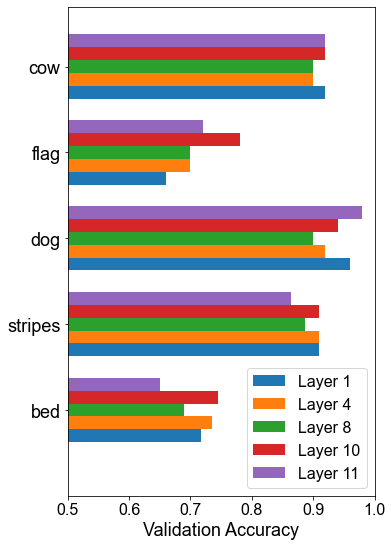

In [310]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=concepts, **concept_scores)) 

ind = np.arange(len(df))
width = 0.15

fig, ax = plt.subplots(figsize=[5.5, 9])
for l, layer in enumerate(layers):
    ax.barh(ind + l*width, df['Layer ' + str(layer)], width, label='Layer ' + str(layer + 1))

ax.set(yticks=ind + 2*width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(prop={'family':'Arial', 'size':16})
ax.set_xlim([0.5, 1])

plt.xticks(fontname='Arial', fontsize=16)
plt.xlabel('Validation Accuracy', fontname='Arial', fontsize=18)
plt.yticks(fontname='Arial', fontsize=18)

# Set up the Model

In [311]:
model_name = "squeezenet"
batch_size = 8
num_epochs = 5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(use_pretrained=True):
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [312]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetBottom, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[1])

    def forward(self, x):
        x = x.view((-1, 512, 13, 13))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model):    
    model_bottom = SqueezenetBottom(model)
    model_top = SqueezenetTop(model)
    return model_bottom, model_top

model_bottom, model_top = get_model_parts(model_ft)
model_bottom.eval()
model_top.eval();

# Evaluation Methods

In [313]:
response = requests.get("https://git.io/JJkYN")
class_labels = response.text.split("\n")

In [314]:
def get_concept_scores(tensor, label):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [316]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\zebra-fig1a.jpg").convert("RGB")
tensor = data_transforms(img).unsqueeze(0)

In [432]:
concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(10), 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra')

concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(7), 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra')

In [433]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.7861298157612224


In [434]:
from scipy.stats import pearsonr


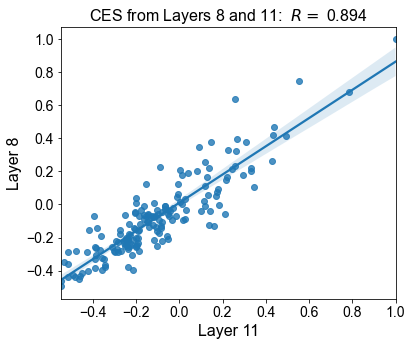

In [435]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Layers 8 and 11:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Layer 11', fontname='Arial', fontsize=16)
plt.ylabel('Layer 8', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [436]:
concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(10), 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra')

concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(0), 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra')

In [437]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.6414172745652935


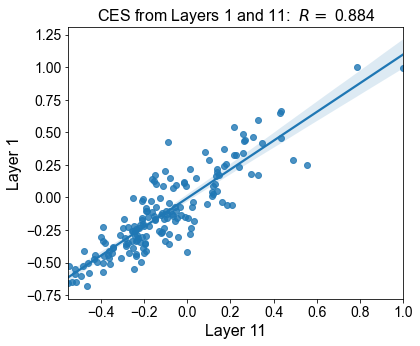

In [438]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Layers 1 and 11:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Layer 11', fontname='Arial', fontsize=16)
plt.ylabel('Layer 1', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [372]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))

In [388]:
def get_concept_scores_with_delta(tensor, label, multiplier):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
        
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
    
    m = np.max(np.abs(list(concept_scores.values())))
    for c in concept_scores:
        concept_scores[c] = concept_scores[c] / m
    
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [422]:
all_scores = []
deltas = [1, 10, 100, 1000, 10000, 100000]

for delta in deltas:
    _, scores, lst = get_concept_scores_with_delta(tensor, 'zebra', delta)
    all_scores.append(scores)

In [423]:
top_concepts = lst[:5]

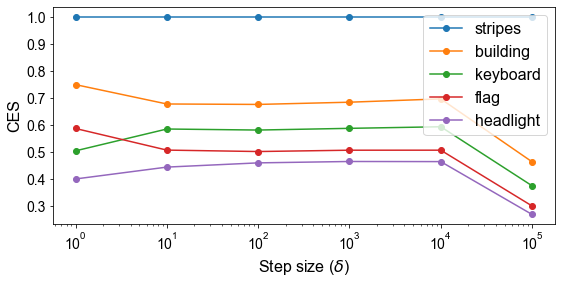

In [441]:
plt.figure(figsize=[9, 4])
for c in top_concepts:
    if c=="stripes":
        plt.semilogx(deltas, [1 for i in range(len(all_scores))], '-o', label=c)
    else:
        plt.semilogx(deltas, [all_scores[i][c] for i in range(len(all_scores))], '-o', label=c)
    
plt.legend(prop={'family':'Arial', 'size':16})
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Step size ($\delta$)', fontname='Arial', fontsize=16)
plt.ylabel('CES', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);